### Multiplex Network Construction Documentation

In this document, we describe the construction of a multiplex network based on the incident data from the Oklahoma Gas and Electric company. The multiplex network consists of multiple layers, each representing different types of connections between the substations.

#### Layers in the Multiplex Network

1. **Job Region**
   - **Description**: This layer represents the geographical regions where the substations are located. Nodes (substations) are connected if they belong to the same job region.
   
2. **Job Area (DISTRICT)**
   - **Description**: This layer represents the specific districts within the regions. Nodes are connected if they belong to the same job area or district.
   
3. **Month/Day/Year**
   - **Description**: This temporal layer represents the date on which incidents occurred. Nodes are connected if incidents at these substations occurred on the same day.
   
4. **Custs Affected Interval**
   - **Description**: This layer categorizes incidents based on the number of customers affected. Nodes are connected if the number of affected customers falls within the same interval (Very Low, Low, Medium, High).
   
5. **OGE Causes**
   - **Description**: This layer categorizes incidents based on their causes as defined by the Oklahoma Gas and Electric company. Nodes are connected if incidents share the same cause.
   
6. **Major Storm Event (Yes or No)**
   - **Description**: This layer represents whether an incident occurred during a major storm event. Nodes are connected if incidents at these substations were affected by the same storm event (Yes or No).
   
7. **Distribution, Substation, Transmission Type**
   - **Description**: This layer represents the type of infrastructure associated with the incidents. Nodes are connected if they belong to the same type, such as distribution, substation, or transmission.

These layers collectively provide a comprehensive view of the different relationships and interactions between the substations based on various criteria, enabling a detailed analysis of the incident data.


In [ ]:
# Multiplex Network Creation

import pandas as pd
import networkx as nx
import itertools
import numpy as np
import os

# Load the dataset
file_path = '/Volumes/Data/NDSU/PhD Work/Research/IME Research/AI-Energy/Data/SPP/Incidents_5000.xlsx'
data = pd.read_excel(file_path)

# Preprocess data: replace spaces in 'Job Substation' names with underscores
data['Job Substation'] = data['Job Substation'].str.replace(' ', '_')

# Define intervals for 'Custs Affected Interval'
custs_intervals = {
    'Very Low': (0, 50),
    'Low': (51, 100),
    'Medium': (101, 500),
    'High': (501, float('inf'))
}

def categorize_custs_affected(affected):
    for category, (low, high) in custs_intervals.items():
        if low <= affected <= high:
            return category
    return 'Unknown'

# Add a column for categorized customer affected intervals
data['Custs Affected Interval'] = data['Custs Affected'].apply(categorize_custs_affected)

# Initialize a dictionary to hold each layer's graph
layers = {
    'Job Region': nx.Graph(),
    'Job Area (DISTRICT)': nx.Graph(),
    'Time': nx.Graph(),
    'Custs Affected Interval': nx.Graph(),
    'OGE Causes': nx.Graph(),
    'Major Storm Event': nx.Graph(),
    'Distribution, Substation, Transmission': nx.Graph()
}

# Add nodes with replaced spaces
for layer in layers:
    nodes = [substation.replace(' ', '_') for substation in data['Job Substation'].unique()]
    layers[layer].add_nodes_from(nodes)

# Define functions to add edges to each layer based on criteria
def add_edges_by_column(layer_name, column):
    layer = layers[layer_name]
    for _, group in data.groupby(column):
        nodes = [substation.replace(' ', '_') for substation in group['Job Substation']]
        for node1, node2 in itertools.combinations(nodes, 2):
            layer.add_edge(node1, node2)

def add_edges_by_date(layer_name):
    layer = layers[layer_name]
    for _, group in data.groupby('Month/Day/Year'):
        nodes = [substation.replace(' ', '_') for substation in group['Job Substation']]
        for node1, node2 in itertools.combinations(nodes, 2):
            layer.add_edge(node1, node2)

# Add edges for each layer
add_edges_by_column('Job Region', 'Job Region')
add_edges_by_column('Job Area (DISTRICT)', 'Job Area (DISTRICT)')
add_edges_by_date('Time')
add_edges_by_column('Custs Affected Interval', 'Custs Affected Interval')
add_edges_by_column('OGE Causes', 'OGE Causes')
add_edges_by_column('Major Storm Event', 'Major Storm Event  Y (Yes) or N (No)')
add_edges_by_column('Distribution, Substation, Transmission', 'Distribution, Substation, Transmission')

# Custom class to represent a multiplex network
class MultiplexNetwork:
    def __init__(self):
        self.layers = {}
        self.node_set = set()
        
    def add_layer(self, layer_name, graph):
        self.layers[layer_name] = graph
        self.node_set.update(graph.nodes)
        
    def get_layer(self, layer_name):
        return self.layers.get(layer_name, None)
    
    def nodes(self):
        return self.node_set
    
    def edges(self, layer_name=None):
        if layer_name:
            return self.layers[layer_name].edges
        else:
            all_edges = {}
            for layer, graph in self.layers.items():
                all_edges[layer] = list(graph.edges)
            return all_edges

# Create the multiplex network
multiplex_network = MultiplexNetwork()
for layer_name, graph in layers.items():
    multiplex_network.add_layer(layer_name, graph)

# Interact with the multiplex network
#print(f"All nodes in multiplex network: {multiplex_network.nodes()}")
#for layer_name in layers:
    #print(f"Edges in {layer_name} layer: {multiplex_network.edges(layer_name)}")

# print the number of nodes and edges in each layer
for layer_name in layers:
    print(f"Number of nodes in {layer_name} layer: {len(layers[layer_name].nodes)}")
    print(f"Number of edges in {layer_name} layer: {len(layers[layer_name].edges)}")    


In [ ]:
# Save adjacency matrices of each layer as CSV files

# Define the directory to save the adjacency matrices
output_dir = '/Volumes/Data/NDSU/PhD Work/Research/IME Research/AI-Energy/Data/SPP/adjacency_matrices'
os.makedirs(output_dir, exist_ok=True)

# Function to save adjacency matrix of each layer
def save_adjacency_matrices(multiplex_network, output_dir):
    for layer_name, graph in multiplex_network.layers.items():
        # Create adjacency matrix
        adjacency_matrix = nx.to_numpy_array(graph)
        
        # Convert adjacency matrix to DataFrame for CSV export
        adjacency_df = pd.DataFrame(adjacency_matrix, index=graph.nodes, columns=graph.nodes)
        
        # Define file path
        file_path = os.path.join(output_dir, f"{layer_name.replace(' ', '_')}_adjacency_matrix.csv")
        
        # Save adjacency matrix as .csv file
        adjacency_df.to_csv(file_path)
        print(f"Adjacency matrix for layer '{layer_name}' saved at: {file_path}")

# Assuming `multiplex_network` is your existing multiplex network object
save_adjacency_matrices(multiplex_network, output_dir)


After the adjacency matrices formation, we generate the Multiplex Network Embeddings using the [multi-node2vec model](https://github.com/jdwilson4/multi-node2vec) and in the next step we will combine those embeddings with our target variable i.e. Extent to prepare for the machine learning.


In [ ]:
# Preparing the datasets for Machine Learning

# Load the datasets
incidents_file_path = '/Volumes/Data/NDSU/PhD Work/Research/IME Research/AI-Energy/Data/SPP/Incidents_5000.xlsx'  # Update with your file path
embeddings_file_path = '/Volumes/Data/NDSU/PhD Work/Research/IME Research/AI-Energy/Data/SPP/embeddings_new/r0.25/mltn2v_results.csv'  # Update with your file path

# Read the files
incidents_data = pd.read_excel(incidents_file_path)
embeddings_data = pd.read_csv(embeddings_file_path)

# Ensure 'Job Substation' in incidents_data matches the embedding keys
incidents_data['Job Substation'] = incidents_data['Job Substation'].str.replace(' ', '_')

# Merge the embeddings data with only the 'Extent' column from the incidents data
reduced_incidents_data = incidents_data[['Job Substation', 'Extent']]

# Merge the embeddings data with the reduced incidents data
merged_data_corrected = pd.merge(reduced_incidents_data, embeddings_data, left_on='Job Substation', right_on=embeddings_data.columns[0], how='inner')

# Drop the substation identifier column from embeddings data
merged_data_corrected = merged_data_corrected.drop(columns=[embeddings_data.columns[0]])

# Save the merged data to a CSV file
output_file_path = '/Volumes/Data/NDSU/PhD Work/Research/IME Research/AI-Energy/Data/SPP/merged_data_n.csv'  # Update with your desired output path
merged_data_corrected.to_csv(output_file_path, index=False)

print(f"Merged data saved to {output_file_path}")


In [ ]:
# Machine Learning with the Prepared Datasets(Using the Embeddings)
# Install the imblearn library
!pip install imbalanced-learn

import pandas as pd
from sklearn.preprocessing import LabelEncoder
from sklearn.model_selection import train_test_split, GridSearchCV
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import classification_report, accuracy_score
from imblearn.over_sampling import SMOTE

# Load the merged data
merged_file_path = '/Volumes/Data/NDSU/PhD Work/Research/IME Research/AI-Energy/Data/SPP/merged_data_n.csv'
merged_data = pd.read_csv(merged_file_path)

# Define the target variable
target_column = 'Extent'

# Extract embedding columns (all columns except the target)
embedding_columns = merged_data.columns[2:]  # Excluding 'Job Substation' and 'Extent'

# Select features (embeddings) and target
X = merged_data[embedding_columns]
y = merged_data[target_column]

# Initialize label encoder
le = LabelEncoder()

# Encode the target variable
y_encoded = le.fit_transform(y)

# Ensure all feature columns are numeric
X = X.apply(pd.to_numeric, errors='coerce')

# Handle missing values (fill with median values)
X = X.fillna(X.median())

# Drop rows with missing values if any
if X.isnull().sum().sum() > 0:
    X.dropna(inplace=True)
    y_encoded = y_encoded[X.index]

# Balance the dataset using SMOTE
smote = SMOTE(random_state=42)
X_resampled, y_resampled = smote.fit_resample(X, y_encoded)

# Split the data into training and testing sets
X_train, X_test, y_train, y_test = train_test_split(X_resampled, y_resampled, test_size=0.2, random_state=42)

# Define the parameter grid for GridSearchCV
param_grid = {
    'n_estimators': [100, 200, 300],
    'max_depth': [10, 20, 30, None],
    'min_samples_split': [2, 5, 10],
    'min_samples_leaf': [1, 2, 4],
    'bootstrap': [True, False]
}

# Initialize the Random Forest classifier
rf = RandomForestClassifier(random_state=42)

# Initialize GridSearchCV
grid_search = GridSearchCV(estimator=rf, param_grid=param_grid, cv=3, n_jobs=-1, verbose=2)

# Fit GridSearchCV
grid_search.fit(X_train, y_train)

# Get the best estimator
best_rf = grid_search.best_estimator_

# Make predictions with the best estimator
y_pred = best_rf.predict(X_test)

# Evaluate the model
accuracy = accuracy_score(y_test, y_pred)
report = classification_report(y_test, y_pred, target_names=le.classes_)

print(f"Accuracy: {accuracy}")
print("Classification Report:")
print(report)


['Secondary' 'Mainline' 'Load' 'Customer' 'Feeder' 'Tap' 'Substation']
Job CAIDI    0.142348
Call Qty     0.106420
Cause ID     0.102920
Name: Extent_encoded, dtype: float64


/Users/muhammadkazim/Library/Python/3.9/lib/python/site-packages/seaborn/matrix.py:256: FutureWarning: Format strings passed to MaskedConstant are ignored, but in future may error or produce different behavior
  annotation = ("{:" + self.fmt + "}").format(val)


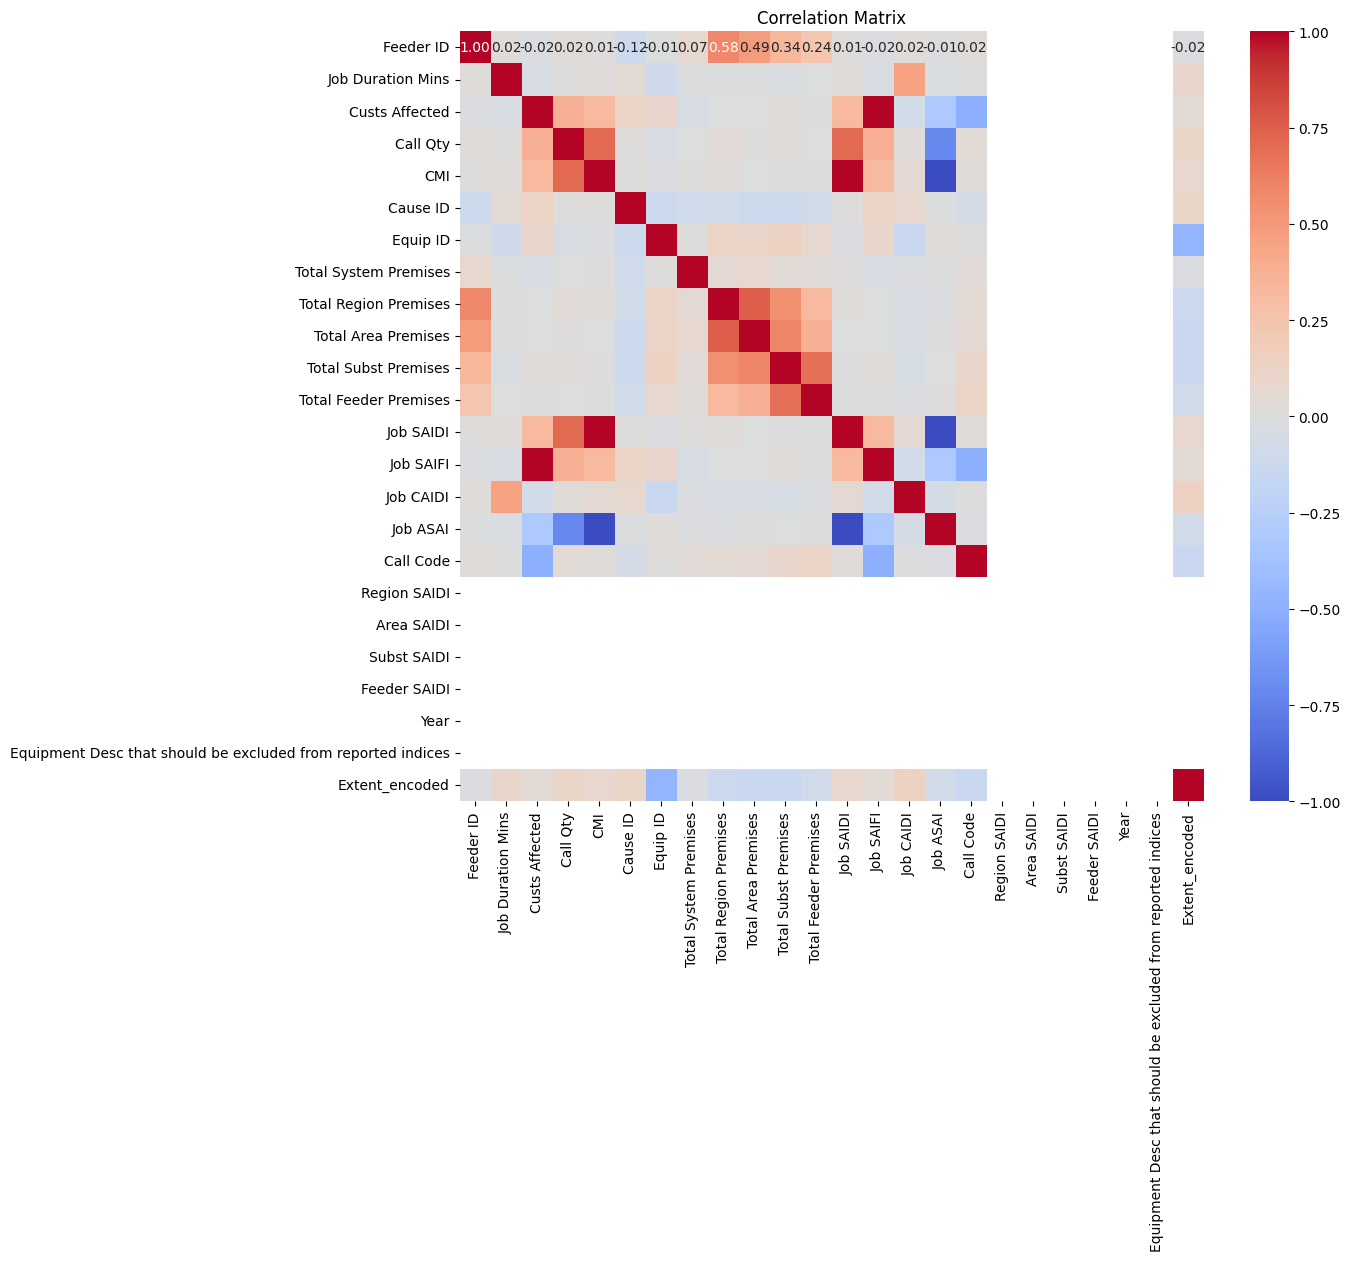

In [10]:
# Findings the most important features (Corelated Features)
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.preprocessing import LabelEncoder

# Load the Excel file
file_path = '/Volumes/Data/NDSU/PhD Work/Research/IME Research/AI-Energy/Data/SPP/Incidents_5000.xlsx'
data = pd.read_excel(file_path)

# Display the first few rows of the dataframe to understand its structure
#print(data.head())

# Checking the datatype of the columns to find out why 'Extent' might not be present in the correlation matrix
#print(data.dtypes)

# Inspect unique values in the 'Extent' column
unique_extent_values = data['Extent'].unique()
print(unique_extent_values)

# Create a label encoder
label_encoder = LabelEncoder()

# Encode the 'Extent' column
data['Extent_encoded'] = label_encoder.fit_transform(data['Extent'])

# Recalculate correlation matrix with the encoded 'Extent' column
correlation_matrix_encoded = data.corr(numeric_only=True)

# Get the correlation of all columns with the 'Extent_encoded' column
extent_correlation_encoded = correlation_matrix_encoded['Extent_encoded'].drop('Extent_encoded')

# Get the top 3 correlated columns with 'Extent_encoded'
top_3_correlated_columns = extent_correlation_encoded.nlargest(3)
print(top_3_correlated_columns)

# Display the correlation matrix
plt.figure(figsize=(12, 10))
sns.heatmap(correlation_matrix_encoded, annot=True, fmt='.2f', cmap='coolwarm', vmin=-1, vmax=1)
plt.title('Correlation Matrix')
plt.show()


In [6]:
# Accuracy of the model with and without the 'Job CAIDI' column
import pandas as pd
from sklearn.model_selection import train_test_split
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import accuracy_score
from sklearn.preprocessing import LabelEncoder

# Load the data
file_path = '/Volumes/Data/NDSU/PhD Work/Research/IME Research/AI-Energy/Data/SPP/Incidents_5000.xlsx'
data = pd.read_excel(file_path)

# Encode the 'Extent' column
label_encoder = LabelEncoder()
data['Extent_encoded'] = label_encoder.fit_transform(data['Extent'])

# Drop columns that are not useful for the model
data = data.drop(columns=['Extent', 'Job OFF Time', 'Job ON Time', 'Month/Day/Year'])

# Prepare the feature set and target
X = data.drop(columns=['Extent_encoded'])
y = data['Extent_encoded']

# Handle categorical variables using one-hot encoding
X = pd.get_dummies(X, drop_first=True)

# Split the data into training and testing sets
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

# Train a RandomForestClassifier on the full dataset
model_full = RandomForestClassifier(random_state=42)
model_full.fit(X_train, y_train)

# Make predictions and evaluate accuracy
y_pred_full = model_full.predict(X_test)
accuracy_full = accuracy_score(y_test, y_pred_full)

print("Accuracy with all features:", accuracy_full)

# Remove the 'Job CAIDI' column
X_reduced = X.drop(columns=['Job CAIDI'])

# Split the data into training and testing sets again
X_train_reduced, X_test_reduced, y_train_reduced, y_test_reduced = train_test_split(X_reduced, y, test_size=0.2, random_state=42)

# Train a RandomForestClassifier on the reduced dataset
model_reduced = RandomForestClassifier(random_state=42)
model_reduced.fit(X_train_reduced, y_train_reduced)

# Make predictions and evaluate accuracy
y_pred_reduced = model_reduced.predict(X_test_reduced)
accuracy_reduced = accuracy_score(y_test_reduced, y_pred_reduced)

print("Accuracy without 'Job CAIDI':", accuracy_reduced)


Accuracy with all features: 0.8541458541458542
Accuracy without 'Job CAIDI': 0.8561438561438561


In [7]:
# Feature importances of the model with and without the 'Job CAIDI' column
import pandas as pd
from sklearn.model_selection import train_test_split, cross_val_score
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import accuracy_score
from sklearn.preprocessing import LabelEncoder

# Load the data
file_path = '/Volumes/Data/NDSU/PhD Work/Research/IME Research/AI-Energy/Data/SPP/Incidents_5000.xlsx'
data = pd.read_excel(file_path)

# Encode the 'Extent' column
label_encoder = LabelEncoder()
data['Extent_encoded'] = label_encoder.fit_transform(data['Extent'])

# Drop columns that are not useful for the model
data = data.drop(columns=['Extent', 'Job OFF Time', 'Job ON Time', 'Month/Day/Year'])

# Prepare the feature set and target
X = data.drop(columns=['Extent_encoded'])
y = data['Extent_encoded']

# Handle categorical variables using one-hot encoding
X = pd.get_dummies(X, drop_first=True)

# Train a RandomForestClassifier on the full dataset with cross-validation
model_full = RandomForestClassifier(random_state=42)
scores_full = cross_val_score(model_full, X, y, cv=5, scoring='accuracy')
accuracy_full = scores_full.mean()

print("Cross-validated accuracy with all features:", accuracy_full)

# Remove the 'Job CAIDI' column
X_reduced = X.drop(columns=['Job CAIDI'])

# Train a RandomForestClassifier on the reduced dataset with cross-validation
model_reduced = RandomForestClassifier(random_state=42)
scores_reduced = cross_val_score(model_reduced, X_reduced, y, cv=5, scoring='accuracy')
accuracy_reduced = scores_reduced.mean()

print("Cross-validated accuracy without 'Job CAIDI':", accuracy_reduced)

# Feature importances
model_full.fit(X, y)
importances_full = model_full.feature_importances_

model_reduced.fit(X_reduced, y)
importances_reduced = model_reduced.feature_importances_

# Display top 10 important features for both models
feature_names_full = X.columns
feature_names_reduced = X_reduced.columns

importances_df_full = pd.DataFrame({'Feature': feature_names_full, 'Importance': importances_full}).sort_values(by='Importance', ascending=False).head(10)
importances_df_reduced = pd.DataFrame({'Feature': feature_names_reduced, 'Importance': importances_reduced}).sort_values(by='Importance', ascending=False).head(10)

importances_df_full, importances_df_reduced


Cross-validated accuracy with all features: 0.8246377622377622
Cross-validated accuracy without 'Job CAIDI': 0.8252375624375624


(                 Feature  Importance
 2         Custs Affected    0.046061
 13             Job SAIFI    0.035895
 6               Equip ID    0.031386
 4                    CMI    0.028932
 12             Job SAIDI    0.026517
 17523   Device Type_Load    0.024628
 3               Call Qty    0.021176
 1      Job Duration Mins    0.019482
 17522   Device Type_Fuse    0.018685
 14             Job CAIDI    0.018655,
                  Feature  Importance
 13             Job SAIFI    0.035876
 17522   Device Type_Load    0.035599
 2         Custs Affected    0.032673
 6               Equip ID    0.028973
 12             Job SAIDI    0.028443
 4                    CMI    0.024920
 15             Call Code    0.020934
 3               Call Qty    0.020845
 1      Job Duration Mins    0.018529
 17521   Device Type_Fuse    0.018196)